# 1. Data preparation and exploration (35%) 

# 1.1 Creating Spark Session (4%) 
 
1.	Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration  to enable a minimum of  partitions when reading each file in Spark SQL (so each dataframe should have at least 4 partitions when reading from the given datafiles). 


In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
master = "local[*]"
app_name = "Fit5202 Assignment2"
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.files.maxPartitionBytes',16777216)


2.	Then create a SparkSession using the SparkConf object

In [2]:
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR') 

# 1.2 Loading the data (16%) 
 
1.	Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe. 
○	In order to speed up the loading process, please specify the schema before reading the data into dataframes. You may find relevant schema info from the metadata file, however, note that some data may not fully comply with the schema. For those that do not comply with the schema, import them as StringType and further transform them in step 1.2.2. 


In [3]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructType,StructField
schema_memory = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('MINFLT', DoubleType(), True),
                     StructField('MAJFLT', DoubleType(), True),
                     StructField('VSTEXT', DoubleType(), True),
                     StructField('VSIZE', DoubleType(), True),
                     StructField('RSIZE', DoubleType(), True),
                     StructField('VGROW', DoubleType(), True),
                     StructField('RGROW', DoubleType(), True),
                     StructField('MEM', DoubleType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])

In [4]:
df_lm_1 = spark.read.format('csv')\
            .option('header',True)\
            .schema(schema_memory)\
            .load('linux_memory_1.csv')

In [5]:
df_lm_2 = spark.read.format('csv')\
            .option('header',True)\
            .schema(schema_memory)\
            .load('linux_memory_2.csv')

In [6]:
df_lm = df_lm_1.union(df_lm_2)
df_lm.printSchema()
print(df_lm.count())

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

2000000


In [7]:
schema_process = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('TRUN', IntegerType(), True),
                     StructField('TSLPI', IntegerType(), True),
                     StructField('TSLPU', IntegerType(), True),
                     StructField('POLI', StringType(), True),
                     StructField('NICE', IntegerType(), True),
                     StructField('PRI', IntegerType(), True),
                     StructField('RTPR', IntegerType(), True),
                     StructField('CPUNR', IntegerType(), True),
                     StructField('Status', StringType(), True),
                     StructField('EXC', IntegerType(), True),
                     StructField('State', StringType(), True),
                     StructField('CPU', DoubleType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])

In [8]:
df_lp_1 = spark.read.format('csv')\
            .option('header',True)\
            .schema(schema_process)\
            .load('linux_process_1.csv')

In [9]:
df_lp_2 = spark.read.format('csv')\
            .option('header',True)\
            .schema(schema_process)\
            .load('linux_process_2.csv')

In [10]:
df_lp = df_lp_1.union(df_lp_2)
df_lp.printSchema()
print(df_lp.count())

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

1927968


2.	For each column in each dataframe above,  
○	Check the null data (if any) and print out the corresponding count in each column 
○ Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats 


In [11]:
from pyspark.sql.functions import isnan, when, count, col, lit,explode,array

In [12]:
df_lm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_lm.columns]).show()
df_lm=df_lm.na.drop()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|  8800|  8800|    0| 9728|49552| 9737|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [13]:
df_lm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_lm.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [14]:
df_lp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_lp.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



# 1.3 Exploring the data (15%) 
 
1.	Show the count of attack and non-attack in each activity based on the column “attack”, then show the count of each kind of attack in process activity based on the column “type”. 
○	Do you see any class imbalance? Examine and describe what you observe 


In [15]:
import pyspark.sql.functions as F
df_lm.groupBy('attack')\
    .agg(F.count('attack').alias('count'))\
    .withColumn('attack result', when(col('attack') == 1, "attack").otherwise("non-attack"))\
    .select('attack result','count').show()

+-------------+-------+
|attack result|  count|
+-------------+-------+
|       attack| 192922|
|   non-attack|1757524|
+-------------+-------+



In [16]:
df_lp.groupBy('attack')\
    .agg(F.count('attack').alias('count'))\
    .withColumn('attack result', when(col('attack') == 1, "attack").otherwise("non-attack"))\
    .select('attack result','count').show()

+-------------+-------+
|attack result|  count|
+-------------+-------+
|       attack| 291364|
|   non-attack|1636604|
+-------------+-------+



In [17]:
df_lm.filter(col('attack')==1).groupBy('type').agg(F.count('type').alias('count')).show()

+---------+-----+
|     type|count|
+---------+-----+
| password|26016|
|     ddos|36356|
|     mitm|  112|
|injection|58523|
|      dos|71915|
+---------+-----+



In [18]:
df_lp.filter(col('attack')==1).groupBy('type').agg(F.count('type').alias('count')).show()

+---------+-----+
|     type|count|
+---------+-----+
|      xss|17759|
| password|51409|
| scanning|38449|
|     ddos|71603|
|     mitm|  112|
|injection|41311|
|      dos|70721|
+---------+-----+



Comparing Linux process and Linux memory, the number of nonattack is Much larger than attack and do not exsit 'xss'and 'scanning' attack in Linux process.


2.	For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.  
○	No need to show the labels at “attack” or “type” column 


In [19]:
unnum_col_lm = [item[0] for item in df_lm.dtypes if item[1].startswith('string')]
nume_col_lm = [item[0] for item in df_lm.dtypes if item[0] not in unnum_col_lm]
df_lm.select(nume_col_lm).describe().toPandas().head()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,attack
0,count,1950446,1950446,1950446,1950446,1950446,1950446,1950446,1950446,1950446,1950446,1950446
1,mean,1.5562263873997107E9,4994.528547829574,410.0361414773852,1129.0286145322486,2366.7160978053557,4610.658245807024,6266.9833637023785,187.89398558073387,424.2662272628927,0.0032630434269890103,0.09891173608497748
2,stddev,984048.9982963833,4855.911078911934,17360.36571385351,5239.083923877914,6486.300541374661,9131.740908403795,16055.13219572627,2961.0208224821263,1412.3096557875945,0.010554475230237528,0.29854354832415575
3,min,1554216855,1007,0.0,0.0,0.0,0.0,-9728.0,-8652.0,0.0,0.0,0
4,max,1558355716,53096,8050000.0,107776.0,99992.0,88040.0,99932.0,99684.0,98920.0,0.4,1


In [20]:
print(unnum_col_lm)

['CMD', 'type']


In [21]:
df_lm.groupBy(unnum_col_lm[0]).agg(F.count(unnum_col_lm[0]).alias('counts')).sort('counts', ascending=False).show(10)

+----------+------+
|       CMD|counts|
+----------+------+
|      atop|325985|
| jfsCommit| 81714|
|   apache2| 80952|
|  vmtoolsd| 77871|
|      Xorg| 46243|
|  nautilus| 45529|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



In [22]:
df_lm.groupBy(unnum_col_lm[1]).agg(F.count(unnum_col_lm[1]).alias('counts')).sort('counts', ascending=False).show(10)

+---------+-------+
|     type| counts|
+---------+-------+
|   normal|1757524|
|      dos|  71915|
|injection|  58523|
|     ddos|  36356|
| password|  26016|
|     mitm|    112|
+---------+-------+



In [23]:
unnum_col_lp = [item[0] for item in df_lp.dtypes if item[1].startswith('string')]
nume_col_lp = [item[0] for item in df_lp.dtypes if item[0] not in unnum_col_lp]
df_lp.select(nume_col_lp).describe().toPandas().head()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209422,0.1511249149363475
2,stddev,771350.0248085853,4987.784329320536,0.24782587090415972,6.988459728531787,0.04421874419214565,8.403189864752047,22.624445062103057,0.0,1.5274047225902976,1.4619498567691755,0.13628943687184258,0.3581706877473934
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0,0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02,1


In [24]:
print(unnum_col_lp)

['POLI', 'Status', 'State', 'CMD', 'type']


In [25]:
df_lp.groupBy(unnum_col_lp[0]).agg(F.count(unnum_col_lp[0]).alias('counts')).sort('counts', ascending=False).show(10)

+----+-------+
|POLI| counts|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



In [26]:
df_lp.groupBy(unnum_col_lp[1]).agg(F.count(unnum_col_lp[1]).alias('counts')).sort('counts', ascending=False).show(10)

+------+-------+
|Status| counts|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



In [27]:
df_lp.groupBy(unnum_col_lp[2]).agg(F.count(unnum_col_lp[2]).alias('counts')).sort('counts', ascending=False).show(10)

+-----+-------+
|State| counts|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



In [28]:
df_lp.groupBy(unnum_col_lp[3]).agg(F.count(unnum_col_lp[3]).alias('counts')).sort('counts', ascending=False).show(10)

+--------------+------+
|           CMD|counts|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [29]:
df_lp.groupBy(unnum_col_lp[4]).agg(F.count(unnum_col_lp[4]).alias('counts')).sort('counts', ascending=False).show(10)

+---------+-------+
|     type| counts|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



3.	For each activity, present two plots  worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots 
○	Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter plots) for relationship between a column and the “attack” label (such as “ts” and “attack”, “PID” and “attack”); or more advanced plots like correlation plots for relationship between each column; 2: if your data is too large for the plotting, consider using sampling before plotting 
	○	100 words max for each plot’s description and discussion 


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def bar_chart(x, y,a,b, title):
    x_pos = np.arange(len(x))
    a_pos = np.arange(len(a))
    total_width, n = 0.8, 2
    width = total_width / n
    x_pos = x_pos - (total_width - width) / 2
    a_pos = a_pos - (total_width - width) / 2
    plt.bar(x_pos, y,  width=width, label='Linux Memory')
    plt.bar(a_pos + width, b, width=width, label='Linux Process')
    plt.xticks(a_pos,a)
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
def pie_chart(labels_1, sizes_1,labels_2, sizes_2, title):
    
    fig,ax = plt.subplots()
    colors = ['red','green','blue','yellow','pink','cyan','magenta']
    pie_1 = ax.pie(sizes_2,startangle=90,autopct='%1.1f%%',radius=2,pctdistance = 0.9,colors=colors, labels=labels_2)
    pie_2 = ax.pie(sizes_1,startangle=90,autopct='%1.1f%%',radius=1.5,pctdistance = 0.6,colors=colors)

   
    for pie_wedge in pie_1[0]:
        pie_wedge.set_edgecolor('black')
    for pie_wedge in pie_2[0]:
        pie_wedge.set_edgecolor('black')

    ax.set(aspect="equal")
    plt.title(title,y=1.5)
    plt.legend(bbox_to_anchor=(1.6, 0), loc=3, borderaxespad=0)
    plt.show()

In [32]:
rows_lm = df_lm.filter(col('attack')==1).groupBy('type').agg(F.count('type').alias('counts')).orderBy('type').collect()
type_lm = [row.type for row in rows_lm]
count_lm = [row.counts for row in rows_lm]
rows_lp = df_lp.filter(col('attack')==1).groupBy('type').agg(F.count('type').alias('counts')).orderBy('type').collect()
type_lp = [row.type for row in rows_lp]
count_lp = [row.counts for row in rows_lp]

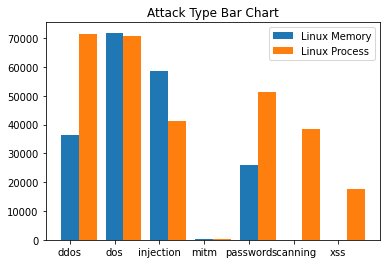

In [33]:
bar_chart(type_lm,count_lm,type_lp,count_lp,'Attack Type Bar Chart')

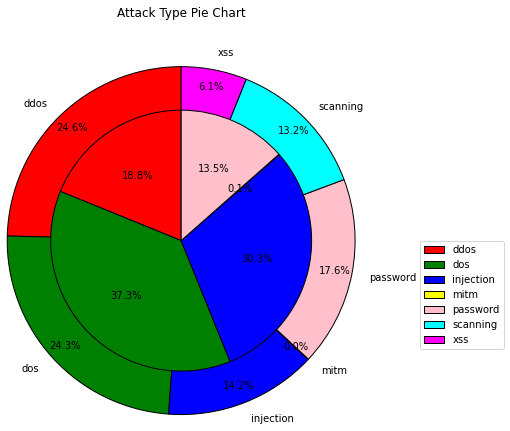

In [34]:
pie_chart(type_lm,count_lm,type_lp,count_lp,'Attack Type Pie Chart')

In [35]:
rows_lm=df_lm.filter(col('attack')==1).groupBy('ts').agg(F.count('attack').alias('counts')).sort('counts', ascending=False).show(10)


+----------+------+
|        ts|counts|
+----------+------+
|1556286993|     3|
|1556302498|     3|
|1556290163|     3|
|1556291188|     3|
|1556291548|     3|
|1556292308|     3|
|1556294008|     3|
|1556294448|     3|
|1556294768|     3|
|1556296488|     3|
+----------+------+
only showing top 10 rows



In [36]:
rows_PID_lm=df_lm.filter(col('attack')==1)\
    .groupBy('PID')\
    .agg(F.count('attack').alias('counts'))\
    .sort('counts', ascending=False).rdd.takeSample(False,10)
type_PID_lm = [row.PID for row in rows_PID_lm]
count_PID_lm = [row.counts for row in rows_PID_lm]

In [37]:
rows_PID_lp=df_lp.filter(col('attack')==1)\
    .groupBy('PID')\
    .agg(F.count('attack').alias('counts'))\
    .sort('counts', ascending=False).rdd.takeSample(False,10)
type_PID_lp = [row.PID for row in rows_PID_lp]
count_PID_lp = [row.counts for row in rows_PID_lp]

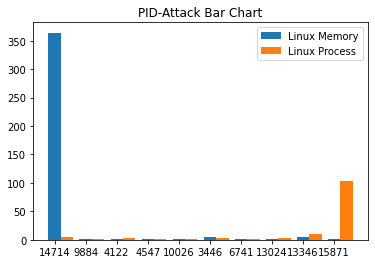

In [38]:
bar_chart(type_PID_lm,count_PID_lm,type_PID_lp,count_PID_lp,'PID-Attack Bar Chart')

In [39]:
rows_ts_lm=df_lm.filter(col('attack')==1)\
    .groupBy('ts')\
    .agg(F.count('attack').alias('counts'))\
    .sort('counts', ascending=False).rdd.takeSample(False,10)
type_ts_lm = [row.ts for row in rows_ts_lm]
count_ts_lm = [row.counts for row in rows_ts_lm]

In [40]:
rows_ts_lp=df_lm.filter(col('attack')==1)\
    .groupBy('ts')\
    .agg(F.count('attack').alias('counts'))\
    .sort('counts', ascending=False).rdd.takeSample(False,10)
type_ts_lp = [row.ts for row in rows_ts_lp]
count_ts_lp = [row.counts for row in rows_ts_lp]

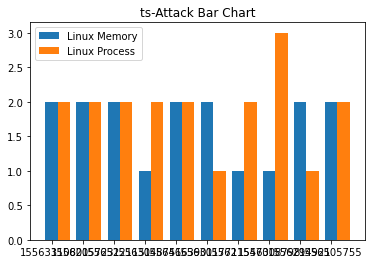

In [41]:
bar_chart(type_ts_lm,count_ts_lm,type_ts_lp,count_ts_lp,'ts-Attack Bar Chart')

Comparing ts column and attack column, I found that in any time stamp servers can be attacked and servers can be attacked in one time stamp.
Comparing PID column and attack column, some PIDs are attacked frequently.
Comparing Type column and attack column, dos and ddos are the most two kinds of attack type.
Comparing Linux Memory and Linux Process, Linux memory don't exist scanning attack and xss attack.

# 2. Feature extraction and ML training (55%)


# 2.1 Preparing the training data and testing data (4%) 
 
1.	Randomly split the dataset into 80% training data and 20% testing data for each use case 


In [42]:
train_lm, test_lm = df_lm.randomSplit([0.8, 0.2], seed=5202)
train_lp, test_lp = df_lp.randomSplit([0.8, 0.2], seed=5202)

2.	With the class imbalance observed from 1.3.1, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20%  attack events data from the training data from 2.1.1. 
Cache the rebalanced training data, and display the count of each event's data. 
	○	Hint - you can use undersampling to get the rebalanced training data 


In [43]:
train_data_lm,drop_data_lm = train_lm.filter(col("attack") == 1).randomSplit([0.2, 0.8], seed=5202)
train_data_lp, drop_data_lp = train_lp.filter(col("attack") == 1).randomSplit([0.2, 0.8], seed=5202)

In [44]:
attack_lm = train_data_lm.filter(col("attack") == 1)
nonattack_lm = df_lm.filter(col("attack") == 0)
ratio = int(nonattack_lm.count() / attack_lm.count())
sampled_majority_df = nonattack_lm.sample(False, 1/(ratio/2))
df_lm_rebalance= sampled_majority_df.unionAll(attack_lm)
df_lm_rebalance.groupby("attack").agg(F.count("attack").alias("Count")).show()

+------+-----+
|attack|Count|
+------+-----+
|     1|30995|
|     0|62656|
+------+-----+



In [45]:
attack_lp = train_data_lp.filter(col("attack") == 1)
nonattack_lp = df_lp.filter(col("attack") == 0)
ratio = int(nonattack_lp.count() / attack_lp.count())
sampled_majority_df = nonattack_lp.sample(False, 1/(ratio/2))
df_lp_rebalance= sampled_majority_df.unionAll(attack_lp)
df_lp_rebalance.groupby("attack").agg(F.count("attack").alias("Count")).show()

+------+-----+
|attack|Count|
+------+-----+
|     1|46594|
|     0|92793|
+------+-----+



# 2.2 Preparing features, labels and models (16%) 
 
1.	Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them . 
○	400 words max for the discussion 
○	Hint - things to consider include whether to scale the numeric data, whether to choose one-hot encoding or string-indexing for a specific model 


In Linux process file,I choose 'ts', 'PID', 'TRUN', 'POLI', 'RTPR', 'Status', 'State', 'CPU' as features.
Because Timestamp can record when server is attacked and PID can show which process is easy to be hacked.
TRUN can show the situation of DDos attack.
RTPR can show whether high priority process can be attack.
Status can show  the attack activity is focus on old process or new process.
CPU can show whether long time excuting attacking process block the system.

In Linux memory file,I choose'MINFLT','RSIZE', 'RGROW','ts','PID','MEM' as features.
Timestamp and PID have same reason from Linux process.
MINFLT can show some attack using error page to attack servers.
RSIZE can show whether an attack uses larger memery to attack servers.
RGROW can show  whether an attack uses applying more memory to attack servers.
MEM can show whether an attack process get to much memory to block process.

2.	Create Transformers / Estimators for transforming / assembling the features you selected above in 2.2.1 


○	(Bonus Task 5%) Create a custom Transformer for the column “POLI” so that the types of policy, [“norm”, “btch”, “idle”, “fifo”, “rr”, “0”, “-”], can be mapped to the following numbers, [0, 1, 2, 3, 4, 5, 6]. 
	i.	Hint - you can create a custom Transform class inheriting from the
	PySpark 	ML 	Transformer, 	HasInputCol, 	HasOutputCol,
DefaultParamsReadable, DefaultParamsWritable class, so that it can be included in the ML Pipeline in the next step. The class should allow users to specify the inputCol, outputCol, originalValues, and newValues parameters when initiating the object. 


In [46]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable  
class replacePOLI(Transformer, HasInputCol, HasOutputCol,DefaultParamsReadable, DefaultParamsWritable):   
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(replacePOLI, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
           
    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def setInputCol(self, value): 
        return self._set(inputCol=value)

    def setOutputCol(self, value):
        return self._set(outputCol=value)

    def _transform(self, df):
        out_col = self.getOutputCol()
        in_col = df[self.getInputCol()]
        temp =df.withColumn(out_col,F.when(df['POLI'] == 'norm', F.lit(0))\
                 .when(df['POLI'] == 'btch',F.lit(1))\
                 .when(df['POLI'] == 'idle', F.lit(2))\
                 .when(df['POLI'] == 'fifo', F.lit(3))\
                 .when(df['POLI'] == 'rr', F.lit(4))\
                 .when(df['POLI'] == '0', F.lit(5))\
                 .when(df['POLI'] == '-', F.lit(6)))
        return temp

In [47]:
replacy_POLI = replacePOLI(inputCol='POLI',outputCol='re_POLI')

In [48]:
from pyspark.ml.feature import StringIndexer
inputCols_lp=['Status','State']
outputCols_lp=[f'{x}_Index' for x in inputCols_lp ]
stage_lp_1 = StringIndexer(inputCols=inputCols_lp, outputCols=outputCols_lp)

from pyspark.ml.feature import OneHotEncoder
inputCols_lp_OHE = [x for x in outputCols_lp]
outputCols_lp_OHE = [f'{x}_vec' for x in inputCols_lp]
stage_lp_2 = OneHotEncoder(inputCols=inputCols_lp_OHE, outputCols=outputCols_lp_OHE)

from pyspark.ml.feature import VectorAssembler
numeric_columns = ['ts','PID', 'TRUN', 'RTPR', 'CPU']
inputCols_lp= numeric_columns + outputCols_lp_OHE
inputCols_lp.append('re_POLI')
stage_lp_3 =VectorAssembler(inputCols= inputCols_lp,outputCol="features") 

In [49]:
inputCols_lm=['MINFLT','RSIZE', 'RGROW','ts','PID','MEM']
stage_lm_3 =VectorAssembler(inputCols= inputCols_lm,outputCol="features") 

3.	Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2 
○	A maximum of two pipelines can be created for each use case 


In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
stage_lm_4 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
pipeline_lm_dt =  Pipeline(stages=[stage_lm_3,stage_lm_4])

In [51]:
from pyspark.ml.classification import GBTClassifier
stage_lm_GBT = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)
pipeline_lm_GBT =  Pipeline(stages=[stage_lm_3,stage_lm_GBT])

In [52]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
stage_lp_4 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
pipeline_lp_dt =  Pipeline(stages=[replacy_POLI,stage_lp_1,stage_lp_2,stage_lp_3,stage_lp_4])

In [57]:
from pyspark.ml.classification import GBTClassifier
stage_lp_GBT = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)
pipeline_lp_GBT =  Pipeline(stages=[replacy_POLI,stage_lp_1,stage_lp_2,stage_lp_3,stage_lp_GBT])

2.3 Training and evaluating models (35%) 
 
1.	For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2  
○	Hint - each model training might take from 1min to 40min, depending on the complexity of the pipeline model, the amount of training data and the VM computing power 


In [58]:
train_lp,test_lp = df_lp_rebalance.randomSplit([0.8,0.2],seed=5202)
model_lp_dt = pipeline_lp_dt.fit(train_lp)
prediction_lp_dt = model_lp_dt.transform(test_lp)
prediction_lp_dt.select('features','attack','probability','prediction').toPandas().head()

,features,attack,probability,prediction
0,"(1554218925.0, 3197.0, 0.0, 0.0, 0.06, 0.0, 0....",0,"[0.9932253313696613, 0.006774668630338734]",0.0
1,"(1554220845.0, 2809.0, 0.0, 0.0, 0.0, 1.0, 0.0...",0,"[0.9932253313696613, 0.006774668630338734]",0.0
2,"(1554221355.0, 3775.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9932253313696613, 0.006774668630338734]",0.0
3,"(1554221450.0, 3780.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9932253313696613, 0.006774668630338734]",0.0
4,"(1554221720.0, 2498.0, 0.0, 0.0, 0.0, 1.0, 0.0...",0,"[0.9932253313696613, 0.006774668630338734]",0.0


In [59]:
model_lp_GBT = pipeline_lp_GBT.fit(train_lp)
prediction_lp_GBT = model_lp_GBT.transform(test_lp)
prediction_lp_GBT.select('features','attack','probability','prediction').toPandas().head()

,features,attack,probability,prediction
0,"(1554218925.0, 3197.0, 0.0, 0.0, 0.06, 0.0, 0....",0,"[0.9341221756527844, 0.06587782434721556]",0.0
1,"(1554220845.0, 2809.0, 0.0, 0.0, 0.0, 1.0, 0.0...",0,"[0.9341221756527844, 0.06587782434721556]",0.0
2,"(1554221355.0, 3775.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527844, 0.06587782434721556]",0.0
3,"(1554221450.0, 3780.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527844, 0.06587782434721556]",0.0
4,"(1554221720.0, 2498.0, 0.0, 0.0, 0.0, 1.0, 0.0...",0,"[0.9341221756527844, 0.06587782434721556]",0.0


In [60]:
train_lm,test_lm = df_lm_rebalance.randomSplit([0.8,0.2],seed=5202)
model_lm_dt = pipeline_lm_dt.fit(train_lm)
prediction_lm_dt = model_lm_dt.transform(test_lm)
prediction_lm_dt.select('features','attack','probability','prediction').toPandas().head()

,features,attack,probability,prediction
0,"[174.0, 5428.0, 5428.0, 1554219150.0, 2009.0, ...",0,"[0.962997134948769, 0.037002865051231]",0.0
1,"[0.0, 5196.0, 0.0, 1554223095.0, 1339.0, 0.0]",0,"[0.962997134948769, 0.037002865051231]",0.0
2,"[0.0, 4392.0, 0.0, 1554223790.0, 1851.0, 0.0]",0,"[0.962997134948769, 0.037002865051231]",0.0
3,"[0.0, 99.8, 0.0, 1554224075.0, 3752.0, 0.03]",0,"[0.962997134948769, 0.037002865051231]",0.0
4,"[366.0, 0.0, 0.0, 1554224625.0, 3912.0, 0.0]",0,"[0.962997134948769, 0.037002865051231]",0.0


In [61]:
model_lm_GBT = pipeline_lm_GBT.fit(train_lm)
prediction_lm_GBT = model_lm_GBT.transform(test_lm)
prediction_lm_GBT.select('features','attack','probability','prediction').toPandas().head()


,features,attack,probability,prediction
0,"[174.0, 5428.0, 5428.0, 1554219150.0, 2009.0, ...",0,"[0.9341221756527827, 0.06587782434721734]",0.0
1,"[0.0, 5196.0, 0.0, 1554223095.0, 1339.0, 0.0]",0,"[0.9341221756527837, 0.06587782434721634]",0.0
2,"[0.0, 4392.0, 0.0, 1554223790.0, 1851.0, 0.0]",0,"[0.9341221756527837, 0.06587782434721634]",0.0
3,"[0.0, 99.8, 0.0, 1554224075.0, 3752.0, 0.03]",0,"[0.9341221756527834, 0.06587782434721656]",0.0
4,"[366.0, 0.0, 0.0, 1554224625.0, 3912.0, 0.0]",0,"[0.9341221756527834, 0.06587782434721656]",0.0


2.	For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label in formats as below.  
  


In [62]:
prediction_lp_dt.groupBy('attack', 'prediction').count().show()

prediction_lp_GBT.groupBy('attack', 'prediction').count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|  282|
|     0|       0.0|15455|
|     1|       1.0| 8981|
|     0|       1.0| 3140|
+------+----------+-----+

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|  803|
|     0|       0.0|17187|
|     1|       1.0| 8460|
|     0|       1.0| 1408|
+------+----------+-----+



In [63]:
prediction_lm_dt.groupBy('attack', 'prediction').count().show()
prediction_lm_GBT.groupBy('attack', 'prediction').count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|  202|
|     0|       0.0|10940|
|     1|       1.0| 5986|
|     0|       1.0| 1556|
+------+----------+-----+

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|  505|
|     0|       0.0|11578|
|     1|       1.0| 5683|
|     0|       1.0|  918|
+------+----------+-----+



3.	Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks. 

In [64]:
def compute_metrics(predictions):
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count()
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall =  TP/(TP+FN)
    f1 = 2/((1/recall)+(1/precision))
    return accuracy,precision,recall,f1  
print(compute_metrics(prediction_lp_dt))
print(compute_metrics(prediction_lp_GBT))
print(compute_metrics(prediction_lm_dt))
print(compute_metrics(prediction_lm_GBT))

(0.8771627539665446, 0.7409454665456645, 0.9695562992551009, 0.8399738121960343)
(0.9206332112858066, 0.8573165788406972, 0.9133110223469718, 0.8844284146150228)
(0.9059087989723827, 0.7936886767435694, 0.9673561732385262, 0.871959213401311)
(0.9238385784628559, 0.8609301620966521, 0.9183904330963154, 0.8887325044960513)


In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lp_GBT = BinaryClassificationEvaluator(labelCol="attack",rawPredictionCol="rawPrediction")
auc_lp_GBT = evaluator_lp_GBT.evaluate(prediction_lp_GBT)
print(auc_lp_GBT)
print(evaluator_lp_GBT.getMetricName())

0.9793510349487535
areaUnderROC


In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lp_dt = BinaryClassificationEvaluator(labelCol="attack",rawPredictionCol="rawPrediction")
auc_lp_dt = evaluator_lp_dt.evaluate(prediction_lp_dt)
print(auc_lp_dt)
print(evaluator_lp_dt.getMetricName())

0.9118373001184908
areaUnderROC


In [67]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lm_dt = BinaryClassificationEvaluator(labelCol="attack",rawPredictionCol="rawPrediction")
auc_lm_dt = evaluator_lm_dt.evaluate(prediction_lm_dt)
print(auc_lm_dt)
print(evaluator_lm_dt.getMetricName())

0.9293413970039903
areaUnderROC


In [68]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lm_GBT = BinaryClassificationEvaluator(labelCol="attack",rawPredictionCol="rawPrediction")
auc_lm_GBT = evaluator_lm_GBT.evaluate(prediction_lm_GBT)
print(auc_lm_GBT)
print(evaluator_lm_GBT.getMetricName())

0.9821997531776425
areaUnderROC


Comparing two different models, in AUC aspect, Gradient Boosted Tree has higher score
In accuracy and precision, Gradient Boosted Tree model has higher score but in  recall, when predicting acording Linux process file,Decision 
Tree model get higher score than Gradient Boosted Tree model.
But when predicting acording Linux process file,Gradient Boosted Tree model get higher score again.


4.	Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model . And visualise the ROC curve for the better model you selected for each use case. 
○	500 words max for the discussion 


In [69]:
model_lp_dt.stages[-1].featureImportances

SparseVector(16, {0: 0.9993, 6: 0.0007})

In [70]:
model_lp_GBT.stages[-1].featureImportances

SparseVector(16, {0: 0.9142, 1: 0.0333, 2: 0.0, 4: 0.0006, 5: 0.0263, 6: 0.004, 7: 0.0002, 8: 0.0001, 9: 0.0205, 10: 0.0008, 11: 0.0, 13: 0.0, 14: 0.0, 15: 0.0})

In [71]:
model_lm_dt.stages[-1].featureImportances

SparseVector(6, {3: 1.0})

In [72]:
model_lm_GBT.stages[-1].featureImportances

SparseVector(6, {0: 0.0831, 1: 0.026, 2: 0.0004, 3: 0.8467, 4: 0.0355, 5: 0.0084})

In decision tree, when using Linuxe process train model, 'ts' is very important feature, it almost decides whether severs are de attacked
In Gradient Boosted Tree, when using Linuxe memory train model,  'ts' also is very important feature and another four important feature are 1,7,8,11 colums' feature

In [73]:
import pyspark.sql.types as T
import numpy as np

threshold_list = np.linspace(0, 1, 20)

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

df_lp_GBT = prediction_lp_GBT.withColumn('probability', to_array('probability'))
df_lm_GBT = prediction_lm_GBT.withColumn('probability', to_array('probability'))

prob_df_lp_GBT = df_lp_GBT.select(df_lp_GBT.probability[0].alias('negative_prob'),\
                               df_lp_GBT.probability[1].alias('positive_prob'),'attack')
prob_df_lm_GBT = df_lm_GBT.select(df_lm_GBT.probability[0].alias('negative_prob'),\
                               df_lm_GBT.probability[1].alias('positive_prob'),'attack')

In [74]:
def get_tpr_fpr(prob_df):
    tpr_list = []
    fpr_list = []
    for threshold in threshold_list:
        prob_df1 = prob_df.withColumn('prediction',\
                                F.when(prob_df.positive_prob > threshold, 1).otherwise(0))
        tn = prob_df1.filter('prediction = 0 AND attack = 0').count()
        tp = prob_df1.filter('prediction = 1 AND attack = 1').count()
        
        fn = prob_df1.filter('prediction = 0 AND attack = 1').count()
        
        fp = prob_df1.filter('prediction = 1 AND attack = 0').count()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

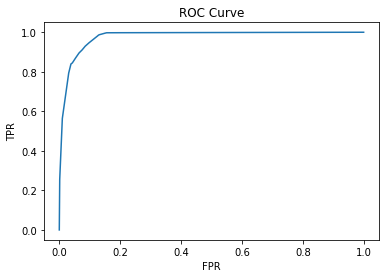

In [75]:
tpr_list, fpr_list = get_tpr_fpr(prob_df_lp_GBT)
plt.plot(fpr_list,tpr_list)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

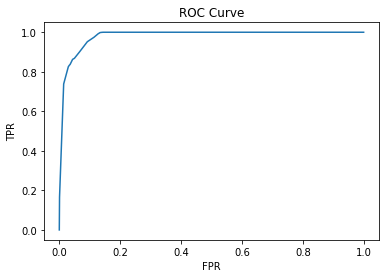

In [76]:
tpr_list, fpr_list = get_tpr_fpr(prob_df_lm_GBT)
plt.plot(fpr_list,tpr_list)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

5.	Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case. 
○	The models would be deployed in Part B of the assignment 2.  


In [77]:
attack_lm_all = df_lm.filter(col("attack") == 1)
nonattack_lm_all = df_lm.filter(col("attack") == 0)
ratio = int(nonattack_lm_all.count() / attack_lm_all.count())
sm_df = nonattack_lm_all.sample(False, 1/(ratio/2))
lm_rebalance= sm_df.unionAll(attack_lm_all)
lm_rebalance.groupby("attack").agg(F.count("attack").alias("Count")).show()

+------+------+
|attack| Count|
+------+------+
|     1|192922|
|     0|391228|
+------+------+



In [78]:
attack_lp_all = df_lp.filter(col("attack") == 1)
nonattack_lp_all = df_lp.filter(col("attack") == 0)
ratio = int(nonattack_lp_all.count() / attack_lp_all.count())
sm_df_lp = nonattack_lp_all.sample(False, 1/(ratio/2))
lp_rebalance= sm_df_lp.unionAll(attack_lp_all)
lp_rebalance.groupby("attack").agg(F.count("attack").alias("Count")).show()

+------+------+
|attack| Count|
+------+------+
|     1|291364|
|     0|655304|
+------+------+



In [79]:
train_lm_rebalance,test_lm_rebalance = lm_rebalance.randomSplit([0.8,0.2],seed=5202)
re_lm_GBT = pipeline_lm_GBT.fit(train_lm_rebalance)
prediction_lm_GBT_re = re_lm_GBT.transform(test_lm_rebalance)
prediction_lm_GBT_re.select('features','attack','probability','prediction').toPandas().head()

,features,attack,probability,prediction
0,"[5238.0, 21044.0, 21044.0, 1554218975.0, 2547....",0,"[0.9341221756527852, 0.06587782434721479]",0.0
1,"[411.0, 728.0, 728.0, 1554219530.0, 3452.0, 0.0]",0,"[0.9341221756527842, 0.06587782434721579]",0.0
2,"[0.0, 11344.0, 0.0, 1554219695.0, 2707.0, 0.0]",0,"[0.9341221756527878, 0.06587782434721223]",0.0
3,"[1.0, 3312.0, 0.0, 1554219755.0, 2753.0, 0.0]",0,"[0.9341221756527878, 0.06587782434721223]",0.0
4,"[0.0, 19576.0, 0.0, 1554219855.0, 3155.0, 0.01]",0,"[0.9341221756527878, 0.06587782434721223]",0.0


In [80]:
train_lp_rebalance,test_lp_rebalance = lp_rebalance.randomSplit([0.8,0.2],seed=5202)
re_lp_GBT = pipeline_lp_GBT.fit(train_lp_rebalance)
prediction_lp_GBT_re = re_lp_GBT.transform(test_lp_rebalance)
prediction_lp_GBT_re.select('features','attack','probability','prediction').toPandas().head()

,features,attack,probability,prediction
0,"(1554218930.0, 2774.0, 0.0, 0.0, 0.06, 0.0, 0....",0,"[0.9341221756527904, 0.06587782434720957]",0.0
1,"(1554219260.0, 2517.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527902, 0.06587782434720979]",0.0
2,"(1554219350.0, 1063.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527858, 0.06587782434721423]",0.0
3,"(1554219395.0, 2008.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527902, 0.06587782434720979]",0.0
4,"(1554219435.0, 2683.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,"[0.9341221756527902, 0.06587782434720979]",0.0


# 3. Knowledge sharing (10%) 
In addition to building the machine learning models, the IT manager from StopHacking would like to learn more about the internals of Spark ML, and plan to replace existing scikit learn clustering logic by Spark KMeans clustering to cater large amounts of data. You are expected to combine the theory from the lecture and the observation from Spark UI to explain what happens when training the KMeans clustering model.  
 
3.1 How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training. (0.5%) 
	
    
    ●	For example, run the following code,  
 
iris_df = spark.createDataFrame([ 
    (4.7, 3.2, 1.3, 0.2), 
    (4.9, 3.1, 1.5, 0.1), 
    (5.4, 3.9, 1.3, 0.4), 
    (5.0, 3.4, 1.6, 0.4), 
    (5.1, 3.8, 1.6, 0.2), 
    (4.9, 2.4, 3.3, 1.0), 
    (6.6, 2.9, 4.6, 1.3), 
    (5.6, 3.0, 4.5, 1.5), 
    (5.7, 2.6, 3.5, 1.0), 
    (5.8, 2.6, 4.0, 1.2), 
    (5.8, 2.8, 5.1, 2.4), 
    (6.2, 2.8, 4.8, 1.8), 
    (6.0, 3.0, 4.8, 1.8), 
    (6.7, 3.1, 5.6, 2.4), 
    (6.7, 3.0, 5.2, 2.3), 
    (6.2, 3.4, 5.4, 2.3)],  
    ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']) 
 
assembler = VectorAssembler(     inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],     outputCol='features') kmeans = KMeans(k=3).fit(assembler.transform(iris_df)) 


In [81]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
iris_df = spark.createDataFrame([ 
    (4.7, 3.2, 1.3, 0.2), 
    (4.9, 3.1, 1.5, 0.1), 
    (5.4, 3.9, 1.3, 0.4), 
    (5.0, 3.4, 1.6, 0.4), 
    (5.1, 3.8, 1.6, 0.2), 
    (4.9, 2.4, 3.3, 1.0), 
    (6.6, 2.9, 4.6, 1.3), 
    (5.6, 3.0, 4.5, 1.5), 
    (5.7, 2.6, 3.5, 1.0), 
    (5.8, 2.6, 4.0, 1.2), 
    (5.8, 2.8, 5.1, 2.4), 
    (6.2, 2.8, 4.8, 1.8), 
    (6.0, 3.0, 4.8, 1.8), 
    (6.7, 3.1, 5.6, 2.4), 
    (6.7, 3.0, 5.2, 2.3), 
    (6.2, 3.4, 5.4, 2.3)],  
    ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']) 
 
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df)) 

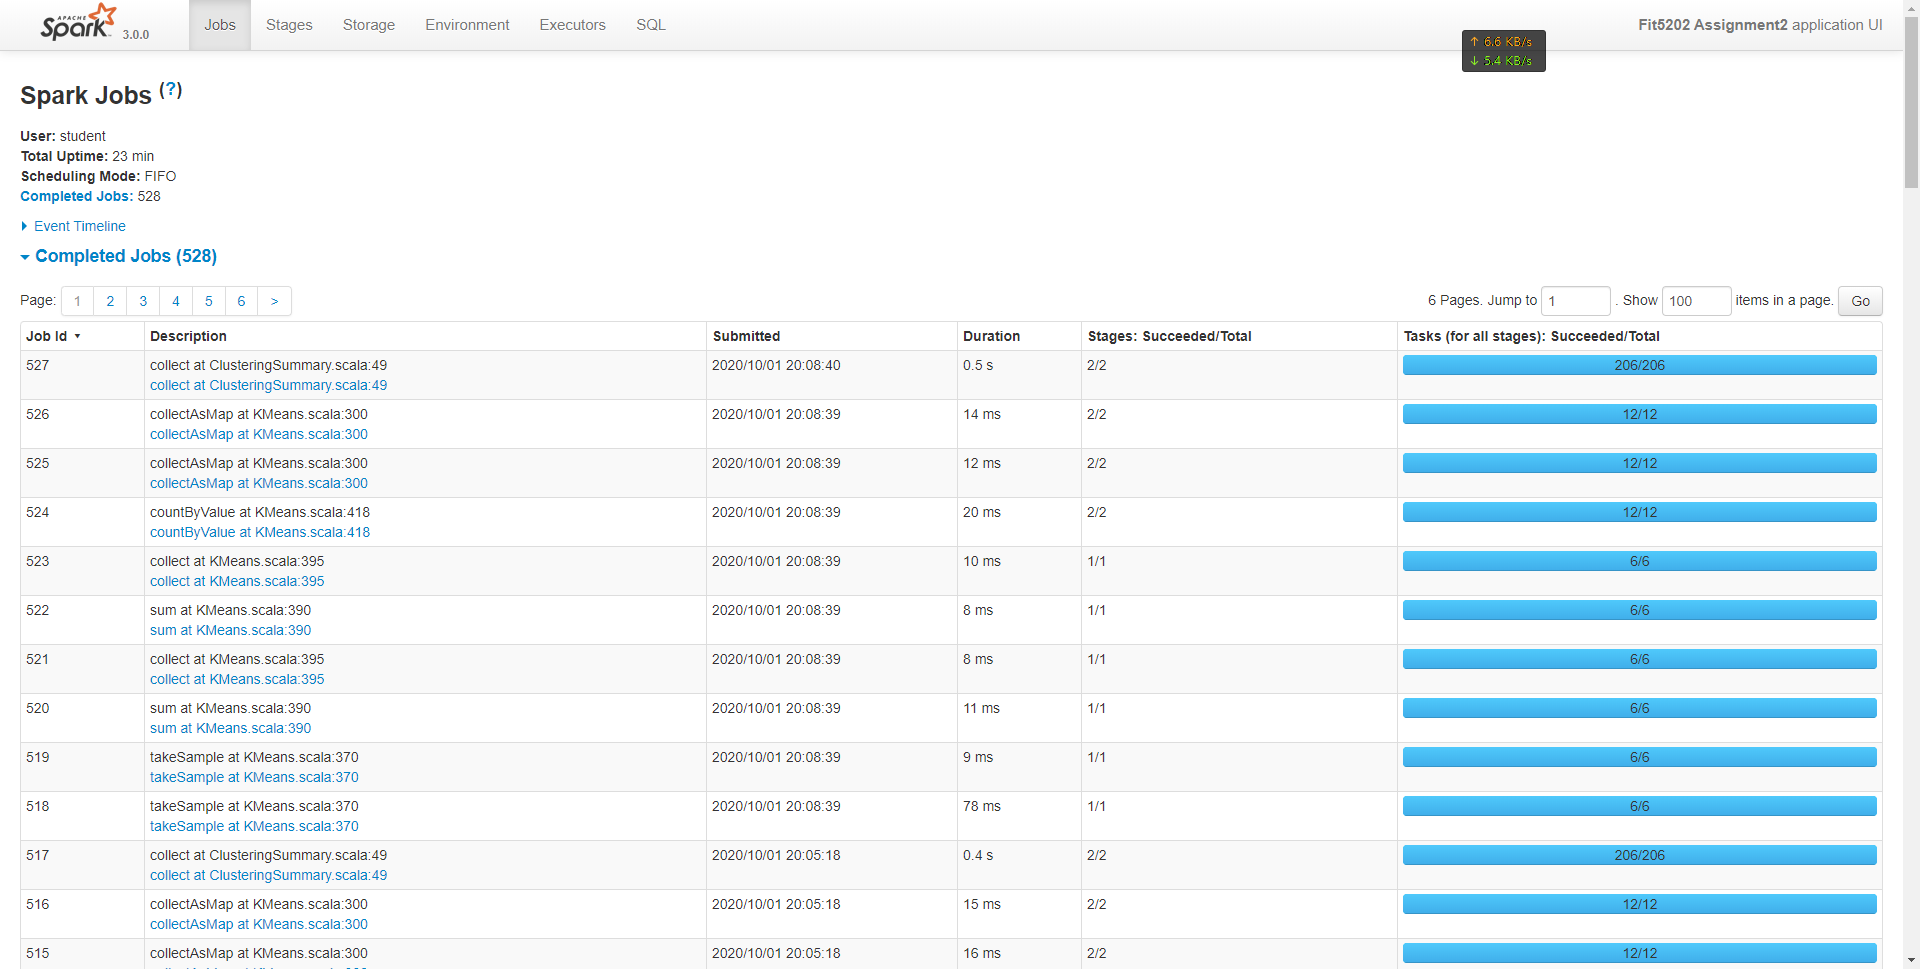


10 jobs

3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents (9.5%) 
●	300 words max for the discussion 
●	Hint 	- 	you 	can 	also 	refer 	to 	the 	Spark 	source 	code 	on 	github https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/ mllib/clustering/KMeans.scala 
 


Kmeans algorithm has 5 steps.
1.Specifies k number of clusters, and guesses the k seed cluster centroid
2.Iteratively looks at each data point and assigns it to the closest centroid
3.Current clusters may receive or loose their members
4.Each cluster must re-calculate the mean (centroid)
5.The process is repeated until the clusters are stable (no change of members)
The 518 and 519 job are choosing a sample at random  as cluster centers. These two jobs refer to the first step.
The 520,521,522 and 523 job are calculating which is the closest cluster center according to a expression for each data and collect each cluster.
The 524 job is re-calculate each cluster's centor.
The 525 and 526 job are collecting each cluster as map(a kind of data type).
The 527 job are creating a summary of Kmeans model.
